In [45]:
# from ZGlobalLib.gpu_utils import use_gpu
# use_gpu(0)

In [46]:
import os
import glob
import numpy as np
import imageio
import random
import tensorflow as tf
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import Sequence, plot_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.utils import to_categorical


In [47]:

def get_files(base_dir, ext=None):
    assert type(ext) in [list, str]
    ext = [ext] if type(ext)!= list else ext
    ret_files = []
    
    for f in glob.glob(f'{base_dir}/**', recursive=True):
        if (ext is not None) and not any([f.endswith(e) for e in ext]):
            continue
        ret_files.append(f)
        
    return ret_files

In [48]:
root_directory = "data\\dataset_2_final\\"

# root_directory = "data/dataset_2_final/"

In [49]:
class_names = sorted([f for f in os.listdir(root_directory) if not f.startswith('.')])
class2int = dict(zip(class_names, range(len(class_names))))
num_classes = len(class_names)

In [50]:
len(labels)

99

In [51]:
image_paths = get_files(root_directory, 'jpg')
print(image_paths)


['data\\dataset_2_final\\aca_bd\\aca_bd_20x_0.jpg', 'data\\dataset_2_final\\aca_bd\\aca_bd_20x_1.jpg', 'data\\dataset_2_final\\aca_bd\\aca_bd_20x_10.jpg', 'data\\dataset_2_final\\aca_bd\\aca_bd_20x_12.jpg', 'data\\dataset_2_final\\aca_bd\\aca_bd_20x_13.jpg', 'data\\dataset_2_final\\aca_bd\\aca_bd_20x_14.jpg', 'data\\dataset_2_final\\aca_bd\\aca_bd_20x_15.jpg', 'data\\dataset_2_final\\aca_bd\\aca_bd_20x_16.jpg', 'data\\dataset_2_final\\aca_bd\\aca_bd_20x_17.jpg', 'data\\dataset_2_final\\aca_bd\\aca_bd_20x_18.jpg', 'data\\dataset_2_final\\aca_bd\\aca_bd_20x_2.jpg', 'data\\dataset_2_final\\aca_bd\\aca_bd_20x_20.jpg', 'data\\dataset_2_final\\aca_bd\\aca_bd_20x_21.jpg', 'data\\dataset_2_final\\aca_bd\\aca_bd_20x_22.jpg', 'data\\dataset_2_final\\aca_bd\\aca_bd_20x_23.jpg', 'data\\dataset_2_final\\aca_bd\\aca_bd_20x_24.jpg', 'data\\dataset_2_final\\aca_bd\\aca_bd_20x_25.jpg', 'data\\dataset_2_final\\aca_bd\\aca_bd_20x_26.jpg', 'data\\dataset_2_final\\aca_bd\\aca_bd_20x_27.jpg', 'data\\dataset

In [52]:

labels = list(map(lambda im: class2int[im.split(root_directory)[1].split('\\')[0]], image_paths))


In [53]:
np.unique(labels, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6]),
 array([ 70,  62,  60, 124,  57,  65,  56], dtype=int64))

In [54]:
class CustomDataGenerator(Sequence):
    def __init__(self, images, labels, batch_size=16, image_size=255, shuffle_epoch=True):
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle_epoch = shuffle_epoch
        
    def __len__(self):
        return int(np.ceil(len(self.images) / self.batch_size))
    
    def __getitem__(self, idx):
        
        if (idx == 0) and (self.shuffle_epoch):            
            # Shuffle at first batch
            c = list(zip(self.images, self.labels))
            random.shuffle(c)
            self.images, self.labels = zip(*c)
            self.images, self.labels = np.array(self.images), np.array(self.labels)       
        
        images = self.images[idx * self.batch_size : (idx+1) * self.batch_size]
        labels = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]
        
        # Read images
        images = np.array([imageio.v2.imread(im) for im in images])
        
        # Choose one of the four quadrants
        x, y = np.random.choice([0,1], size=2)
        images = images[:,(x*600):(x*600 + 600), (y*800):(y*800 + 800)]
        
        images = images/255
        
        images = np.array([self.random_crop(im) for im in images])
        labels = to_categorical(labels, num_classes=num_classes)
        
        return images, labels
    
    def random_crop(self, image):
        cropped_image = tf.image.random_crop(image, size=[self.image_size, self.image_size, 3]).numpy()
        return cropped_image

In [55]:
train_paths, val_paths, train_labels, val_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

In [56]:
train_generator = CustomDataGenerator(train_paths,  train_labels, image_size = 255)
val_generator = CustomDataGenerator(val_paths,  val_labels, shuffle_epoch=False, image_size = 255)

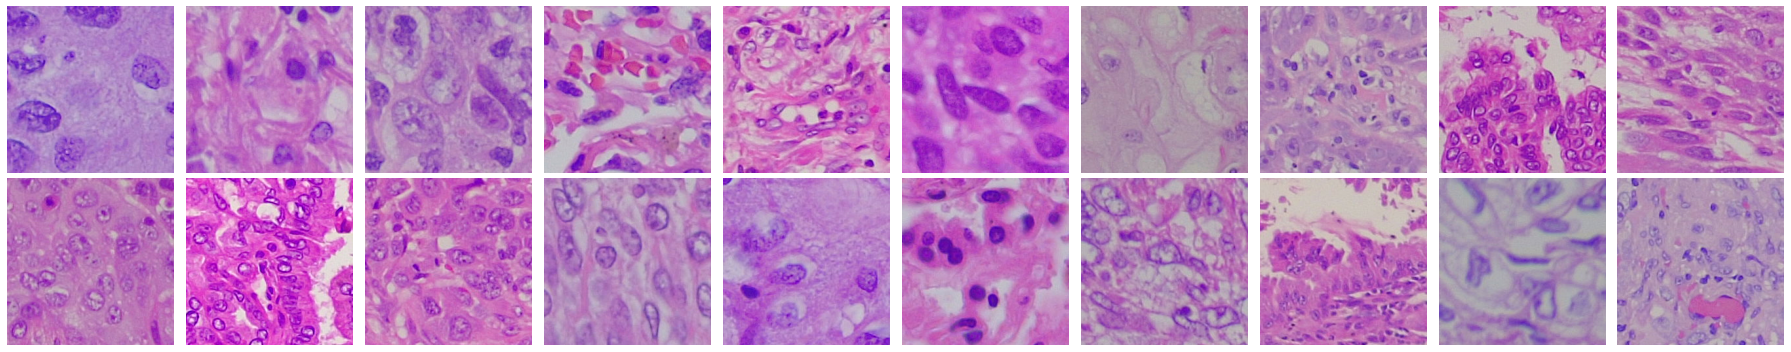

In [57]:
fig, axs = plt.subplots(2,10, figsize=(25,5))
axs = axs.flatten()

for i in range(20):
    gen = train_generator if i<10 else val_generator
    axs[i].imshow(gen[1][0][i%10])
    axs[i].axis('off')
plt.tight_layout()
plt.show()

In [58]:
inp = Input((255,255,3))
x = RandomFlip("horizontal_and_vertical")(inp)
x = EfficientNetB0(include_top=False, pooling='avg')(x)
x = Dense(128, activation='relu')(x)
out = Dense(num_classes, activation='softmax')(x)
model = Model(inp, out)

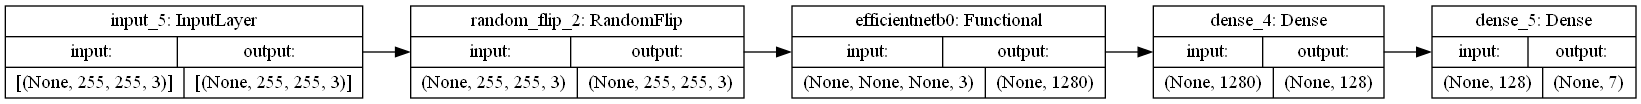

In [59]:
plot_model(model, rankdir='LR', show_shapes=True)

In [60]:
from sklearn.utils import class_weight

In [61]:
labels = np.concatenate([l.argmax(1) for _, l in tqdm(gen, leave=False)])
class_weights = class_weight.compute_class_weight('balanced',
                                                     classes=np.unique(labels),
                                                     y=list(labels))
class_weights = dict(enumerate(class_weights))

  0%|          | 0/7 [00:00<?, ?it/s]

In [62]:
class_weights

{0: 1.010204081632653,
 1: 0.7443609022556391,
 2: 1.7678571428571428,
 3: 0.673469387755102,
 4: 2.020408163265306,
 5: 0.9428571428571428,
 6: 0.9428571428571428}

In [63]:
import datetime
MODEL_NAME = 'Ef0'
RUN_NAME = ''

log_dir = f'logs/{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}/{MODEL_NAME}{RUN_NAME}'
log_dir

'logs/20231001-115750/Ef0'

In [64]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tqdm.keras import TqdmCallback
import tensorflow_addons as tfa


In [65]:

num_epochs = 70
patience = 15
patience_lr = 10

model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='categorical_crossentropy', 
              metrics=[
                    tf.keras.metrics.CategoricalAccuracy(name=f'metrics/accuracy'),
                    tf.keras.metrics.TopKCategoricalAccuracy(3, name=f'metrics/top-3-accuracy'),
                    tfa.metrics.F1Score(num_classes=num_classes, average='macro', name='metrics/F1-macro'),
                    tf.keras.metrics.AUC(multi_label=True, num_labels=num_classes, name='metrics/AUC'),
                    tf.keras.metrics.Precision(name='metrics/precision'),
                    tf.keras.metrics.Recall(name='metrics/recall'),
                    tf.keras.metrics.PrecisionAtRecall(0.99, name='metrics/P@R_99'),
                    tf.keras.metrics.PrecisionAtRecall(0.95, name='metrics/P@R_95'),
                    tf.keras.metrics.PrecisionAtRecall(0.9, name='metrics/P@R_90'),
                    tfa.metrics.MatthewsCorrelationCoefficient(num_classes=num_classes, name='metrics/MCC')
                ],
             )

callbacks =[
       EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=patience),
       ReduceLROnPlateau(monitor='val_loss', patience=patience_lr, min_lr=1e-7),       
       ModelCheckpoint(log_dir, monitor=f"val_loss", save_best_only=True, save_weights_only=True),
       TqdmCallback(),
       #Tensorboard callback
       TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch=0)

]

model.fit(train_generator, epochs=num_epochs, verbose=0, callbacks=callbacks, validation_data=val_generator,
          class_weight=class_weights)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

ResourceExhaustedError:  failed to allocate memory
	 [[node Adam/gradients/sub_45 (defined at C:\Users\diosdadj\AppData\Local\Temp\ipykernel_32544\1687254194.py:31) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_1382541]

Function call stack:
train_function
